In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
import os
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split 

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.applications.inception_v3 import preprocess_input, InceptionV3
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

from PIL import Image
from PIL import ImageFilter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip drive/MyDrive/Colab\ Datasets/DL\ Final/dog-breed-identification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

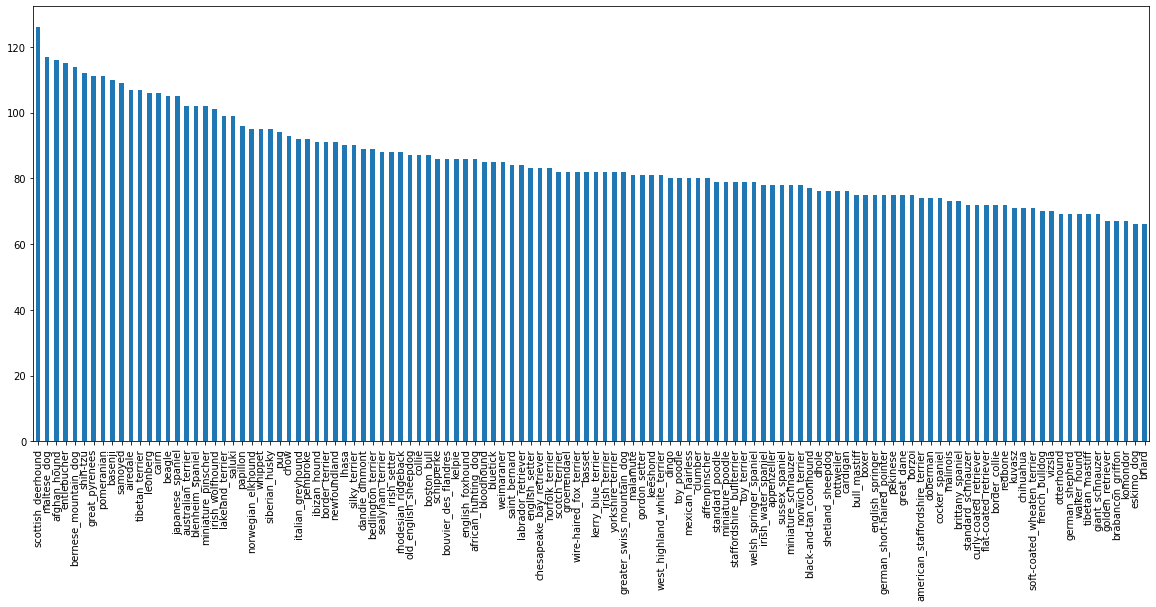

In [5]:
label = pd.read_csv('./labels.csv')

plt.figure(figsize=(20, 8))
label['breed'].value_counts().plot(kind='bar')
plt.show()

In [7]:
np.std(label['breed'].value_counts())

13.242597512908441

In [8]:
label['image_path'] = label.apply(lambda x: ('./train/' + x["id"] + ".jpg" ), axis=1)

train_data = np.array([img_to_array(load_img(img, target_size=(120, 120))) for img in label['image_path'].values.tolist()]).astype('float32')
train_labels = label['breed']


X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, stratify=np.array(train_labels), random_state=42)


In [9]:
data = y_train.value_counts().sort_index().to_frame()
data.columns = ['train']
data['validation'] = y_val.value_counts().sort_index().to_frame()
new_plot = data[['train','validation']].sort_values(['train']+['validation'], ascending=False)
new_plot.head()

,train,validation
scottish_deerhound,113,13
maltese_dog,105,12
afghan_hound,104,12
entlebucher,103,12
bernese_mountain_dog,103,11


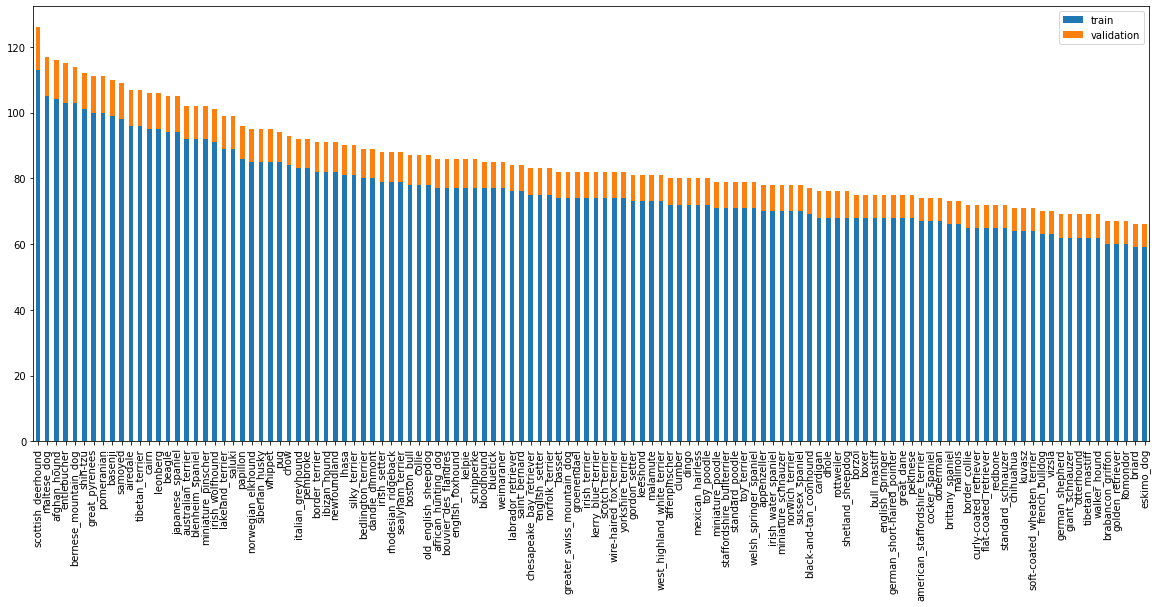

In [13]:
new_plot.plot(kind='bar', stacked=True, figsize=(20,8))
plt.show()

In [19]:
y_train = pd.get_dummies(y_train.reset_index(drop=True))
y_val = pd.get_dummies(y_val.reset_index(drop=True))

In [20]:
train_tensors = preprocess_input(X_train)
valid_tensors = preprocess_input(X_val)

In [21]:
model = InceptionV3(include_top=False)
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_94 (Conv2D)             (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_100 (Batch  (None, None, None,   96         ['conv2d_94[0][0]']              
 Normalization)                 32)                                                    

In [22]:
train_inception = model.predict(train_tensors)
valid_inception = model.predict(valid_tensors)

In [23]:
print(train_inception.shape)

(9199, 2, 2, 2048)


In [24]:
inception = Sequential()
inception.add(GlobalAveragePooling2D(input_shape=train_inception.shape[1:]))

inception.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4),
                                             bias_regularizer=l2(1e-4),
                                             activity_regularizer=l2(1e-5)))
inception.add(BatchNormalization())
inception.add(Dropout(0.1))

inception.add(Dense(512, activation='relu', kernel_regularizer=l2(1e-4),
                                            bias_regularizer=l2(1e-4),
                                            activity_regularizer=l2(1e-5)))
inception.add(BatchNormalization())
inception.add(Dropout(0.1))

inception.add(Dense(120, activation='softmax'))

inception.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 1024)              2098176   
                                                                 
 batch_normalization_194 (Ba  (None, 1024)             4096      
 tchNormalization)                                               
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 batch_normalization_195 (Ba  (None, 512)             

In [25]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.00001, decay=1e-6)
inception.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
checkimprovement = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, restore_best_weights=True)

history_inception = inception.fit(train_inception, y_train, 
                                validation_data=(valid_inception,y_val), 
                                epochs=1000, batch_size=32,
                                callbacks=[checkimprovement]
                               )

Epoch 1/1000


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


288/288 [==============================] - 15s 47ms/step - loss: 5.4183 - accuracy: 0.0269 - val_loss: 4.7812 - val_accuracy: 0.0714
Epoch 2/1000
288/288 [==============================] - 15s 51ms/step - loss: 4.5076 - accuracy: 0.1116 - val_loss: 4.1477 - val_accuracy: 0.1662
Epoch 3/1000
288/288 [==============================] - 15s 51ms/step - loss: 3.8903 - accuracy: 0.2085 - val_loss: 3.7219 - val_accuracy: 0.2356
Epoch 4/1000
288/288 [==============================] - 15s 53ms/step - loss: 3.4550 - accuracy: 0.2842 - val_loss: 3.4443 - val_accuracy: 0.2747
Epoch 5/1000
288/288 [==============================] - 15s 52ms/step - loss: 3.1596 - accuracy: 0.3361 - val_loss: 3.2540 - val_accuracy: 0.3157
Epoch 6/1000
288/288 [==============================] - 15s 52ms/step - loss: 2.9484 - accuracy: 0.3761 - val_loss: 3.1120 - val_accuracy: 0.3324
Epoch 7/1000
288/288 [==============================] - 14s 48ms/step - loss: 2.7542 - accuracy: 0.4130 - val_loss: 3.0186 - val_accuracy

In [26]:
def history(model):
    plt.figure(figsize = (15, 5) )

    plt.subplot(121)
    plt.plot(model.history['loss'], color='blue', label='train')
    plt.plot(model.history['val_loss'], color='red', label='valid')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss Function')

    plt.subplot(122)
    plt.plot(model.history['accuracy'], color = 'blue', label='train')
    plt.plot(model.history['val_accuracy'], color='red', label='valid')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

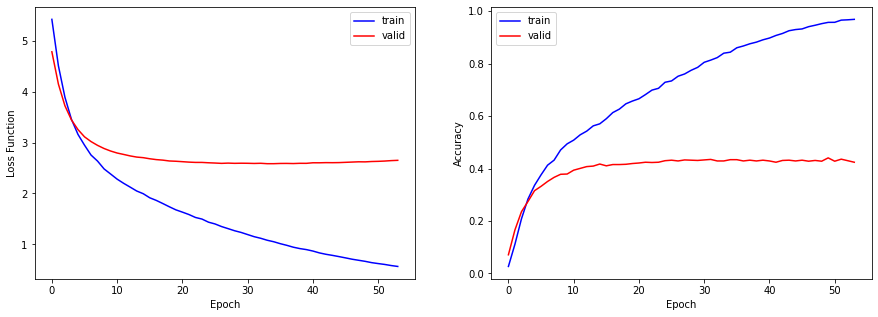

In [27]:
history(history_inception)

In [ ]:
inception.evaluate(valid_inception, y_val)

96/96 [==============================] - 0s 4ms/step - loss: 2.8797 - accuracy: 0.3815


[2.8797013759613037, 0.38148027658462524]

In [ ]:
inception.predict(valid_inception)

array([[4.7463200e-05, 1.9244029e-05, 1.1152194e-05, ..., 3.9380439e-02,
        1.0932209e-06, 5.6861268e-06],
       [4.1101611e-04, 5.1977402e-03, 2.0942654e-02, ..., 8.3163172e-02,
        8.4952917e-05, 2.5164333e-04],
       [1.7935622e-02, 2.5641039e-02, 8.2345624e-03, ..., 3.2927617e-03,
        5.1233254e-04, 9.8588644e-03],
       ...,
       [7.1589713e-04, 1.8679702e-03, 1.6541038e-04, ..., 1.8827015e-05,
        1.5804956e-06, 2.7425194e-04],
       [1.2681271e-07, 3.2829095e-07, 3.7372329e-06, ..., 4.5605775e-05,
        5.1391119e-08, 2.5580727e-08],
       [4.1465287e-06, 7.3301783e-07, 4.0635885e-05, ..., 5.1372958e-06,
        2.9731480e-06, 3.2807358e-05]], dtype=float32)